In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
plt.style.use('seaborn')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
pd.set_option('display.min_rows', 500)
import warnings
warnings.filterwarnings('ignore')

path='../../data/'
train = pd.read_csv(f"{path}/train_data.csv")
test = pd.read_csv(f"{path}/test_data.csv")
sub = pd.read_csv(f"{path}/sample_submission.csv")

In [4]:
def feature_engineering(df):
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    return df

## 기본 정보

In [22]:
print(f"""--- BASIC INFORMATIONS ---
userID(사용자ID)           : {train.userID.nunique()}
assessmentItemID(문항ID)  : {train.assessmentItemID.nunique()}
testID(시험지ID)           : {train.testId.nunique()}
mean answer rate(정답률)   : {train.answerCode.mean():.2%}
KnowledgeTag(문제 유형)     : {train.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID(사용자ID)           : 6698
assessmentItemID(문항ID)  : 9454
testID(시험지ID)           : 1537
mean answer rate(정답률)   : 65.44%
KnowledgeTag(문제 유형)     : 912
--------------------------


In [23]:
print(f"""--- BASIC INFORMATIONS ---
userID(사용자ID)           : {test.userID.nunique()}
assessmentItemID(문항ID)  : {test.assessmentItemID.nunique()}
testID(시험지ID)           : {test.testId.nunique()}
mean answer rate(정답률)   : {test.answerCode.mean():.2%}
KnowledgeTag(문제 유형)     : {test.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID(사용자ID)           : 744
assessmentItemID(문항ID)  : 9454
testID(시험지ID)           : 1537
mean answer rate(정답률)   : 65.22%
KnowledgeTag(문제 유형)     : 912
--------------------------


## train data, test data 확인
- test데이터 26만 개중 맞춰야 되는 행은 744행 (마지막 문제)
    - 테스트 데이터 26만개를 모두 train 데이터로 활용할 수 있지 않을까?
    - 테스트 데이터 744개의 맨 마지막 문제말고 그 앞문제로 validation 하면 되지 않을까?

In [5]:
train[:5]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [6]:
test[:5]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623


In [7]:
sub[:3]

,id,prediction
0,0,0.5
1,1,0.5
2,2,0.5


In [8]:
len(test), len(sub)

(260114, 744)

In [9]:
train_user = set(train.userID)
test_user = set(test.userID)

In [10]:
len(train_user),len(test_user)

(6698, 744)

In [11]:
train_user.intersection(test_user)

set()

## category 변수와 numeric 변수 구분

### category 변수
userID, assessmentItemID, testId, KnowledgeTag

In [14]:
train[:3]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225


### Continuos 변수
Timestamp

## 시험지별 문제 확인

In [34]:
train['problem_number']=train.assessmentItemID.map(lambda x: x[-3:])
train.problem_number.value_counts()

001    371755
003    371640
002    370972
004    369705
005    360607
006    197772
007    127121
008     67150
009     18417
010      5342
011      3352
012      2484
013       269
Name: problem_number, dtype: int64

### 문제 번호별 난이도

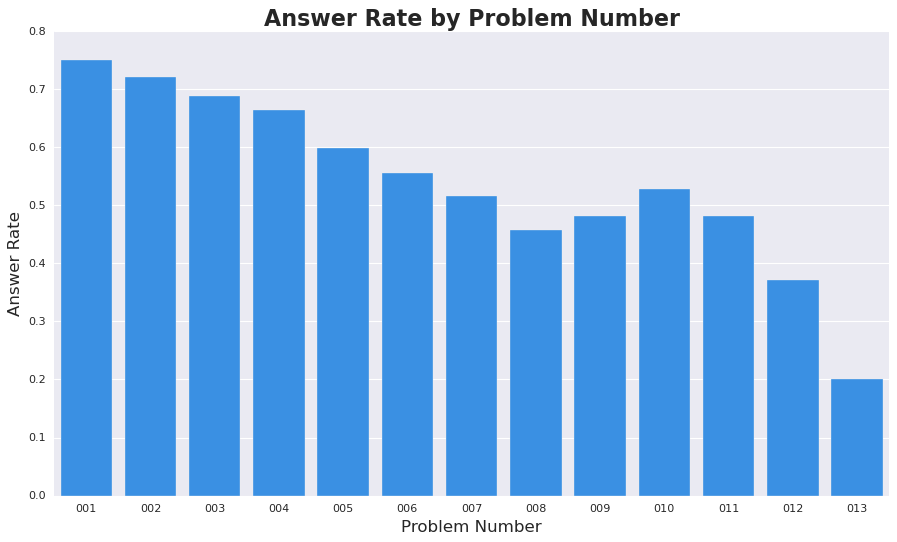

In [104]:
pn_correct = train.groupby('problem_number')['answerCode'].mean().reset_index()
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
q=sns.barplot(pn_correct,x='problem_number',y='answerCode', color="dodgerblue")
q=ax.set_xlabel("Problem Number", fontsize=15)
q=ax.set_ylabel("Answer Rate", fontsize=15)
q=ax.set_title("Answer Rate by Problem Number", fontsize=20, fontweight="semibold")
q=plt.show()

## 시험지의 분류 피처는 무엇을 의미할까?

### 대분류 피처 9가지

In [66]:
train.testId.map(lambda x: x[1:4]).value_counts()

070    279164
050    275773
030    273762
010    272082
020    268327
040    267323
060    264434
080    246336
090    119385
Name: testId, dtype: int64

In [67]:
train.testId.map(lambda x: x[2]).value_counts()

7    279164
5    275773
3    273762
1    272082
2    268327
4    267323
6    264434
8    246336
9    119385
Name: testId, dtype: int64

In [68]:
train['big_category'] = train.testId.map(lambda x: x[2])

#### 대분류별 정답률

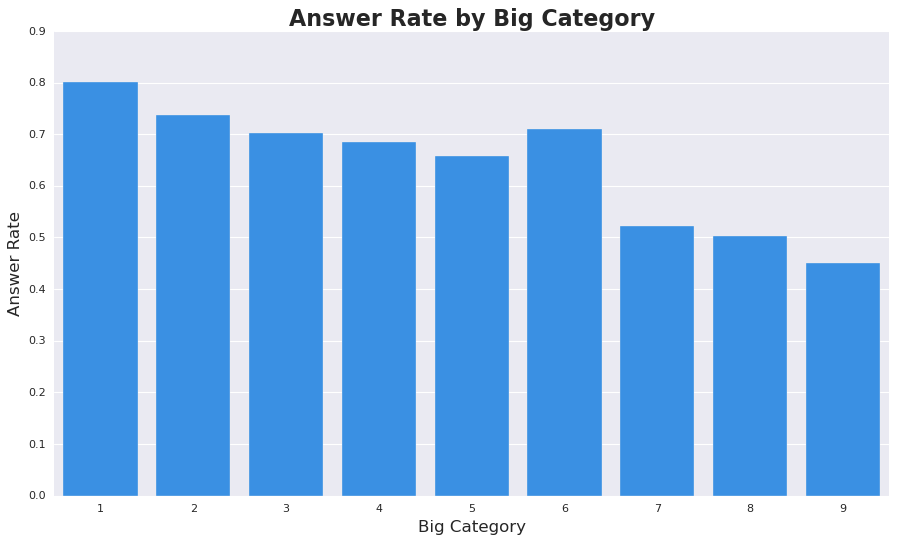

In [105]:
bg_correct = train.groupby('big_category')['answerCode'].mean().reset_index()
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
q=sns.barplot(bg_correct,x='big_category',y='answerCode', color="dodgerblue")
q=ax.set_xlabel("Big Category", fontsize=15)
q=ax.set_ylabel("Answer Rate", fontsize=15)
q=ax.set_title("Answer Rate by Big Category", fontsize=20, fontweight="semibold")
q=plt.show()

### 중분류 피처 198개

In [70]:
train.testId.map(lambda x: x[-3:]).value_counts()

017    17739
009    17555
011    17029
003    16970
007    16826
018    16698
013    16517
015    16436
005    16325
057    16233
019    16050
025    15985
033    15806
047    15511
016    15448
023    15391
034    15081
049    14999
045    14952
055    14920
029    14920
001    14911
027    14851
032    14759
044    14758
021    14751
051    14674
128    14509
127    14473
043    14307
       ...  
169     7328
172     7326
174     7085
171     7048
181     7040
190     6913
175     6903
177     6731
183     6655
185     6619
173     6613
192     6477
179     6451
187     6385
186     6234
193     6173
168     6020
182     5909
166     5564
188     5517
191     5261
195     4417
176     4363
189     4345
178     3824
180     3767
197     2973
194     2596
196     1304
198      951
Name: testId, Length: 198, dtype: int64

In [71]:
len(train.testId.map(lambda x: x[-3:]).value_counts())

198

In [72]:
train['mid_category'] = train.testId.map(lambda x: x[-3:])

In [76]:
cat_df = train.groupby(['big_category','mid_category'])['answerCode'].count().reset_index()
cat_df

,big_category,mid_category,answerCode
0,1,001,1585
1,1,002,1550
2,1,003,1615
3,1,004,1540
4,1,005,1595
5,1,006,1550
6,1,007,1570
7,1,008,1585
8,1,009,1590
9,1,010,1580


In [87]:
for i in range(1,10):
    n=str(i)
    print(f"☄️ 대분류 {n}의 중분류 개수:{len(cat_df[cat_df.big_category==n].mid_category.unique())}")
    print(cat_df[cat_df.big_category==n].mid_category.unique().tolist())
    print()

☄️ 대분류 1의 중분류 개수:192
['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140'

#### 대분류 속에 중분류는 몇개씩 있을까?

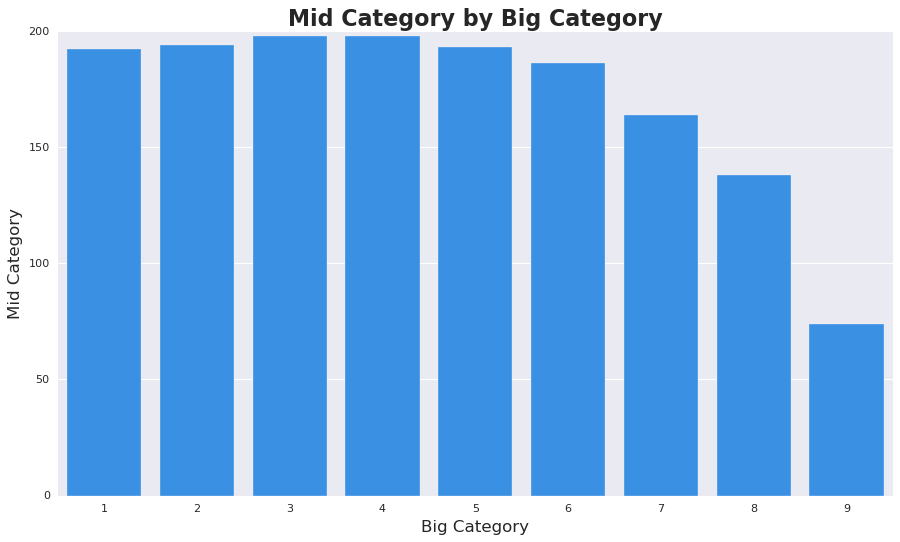

In [108]:
df = train.groupby('big_category')['mid_category'].apply(set).apply(len).reset_index()
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
q=sns.barplot(df,x='big_category',y='mid_category', color="dodgerblue")
q=ax.set_xlabel("Big Category", fontsize=15)
q=ax.set_ylabel("Mid Category", fontsize=15)
q=ax.set_title("Mid Category by Big Category", fontsize=20, fontweight="semibold")
q=plt.show()

#### 문제 번호별로 중분류가 나뉠까?
한 문제 번호에 대해 중분류가 여러개가 있다? problem number 이건 한 문제로 보긴 어렵겠다.

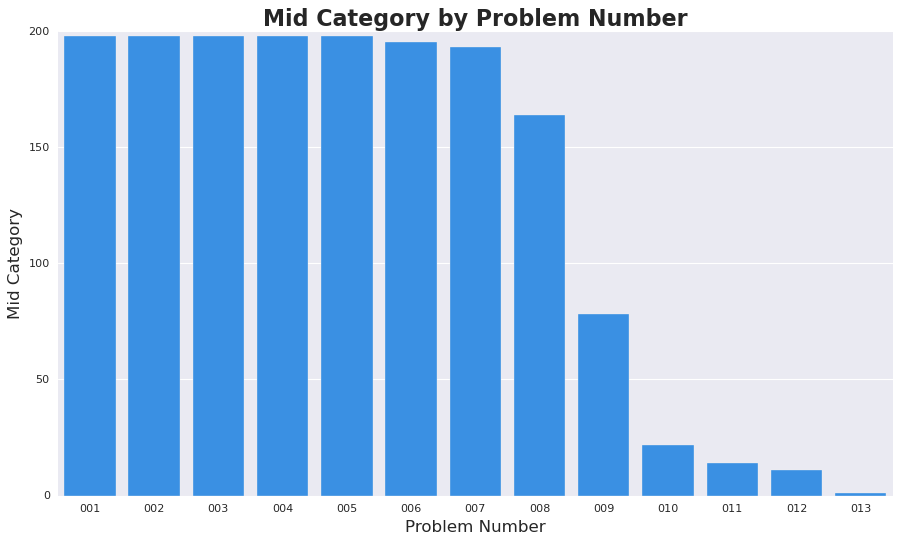

In [112]:
df = train.groupby('problem_number')['mid_category'].apply(set).apply(len).reset_index()
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
q=sns.barplot(df,x='problem_number',y='mid_category', color="dodgerblue")
q=ax.set_xlabel("Problem Number", fontsize=15)
q=ax.set_ylabel("Mid Category", fontsize=15)
q=ax.set_title("Mid Category by Problem Number", fontsize=20, fontweight="semibold")
q=plt.show()

#### 중분류별 정답률 확인 -> 유의미한 패턴은 보이지 않는다.

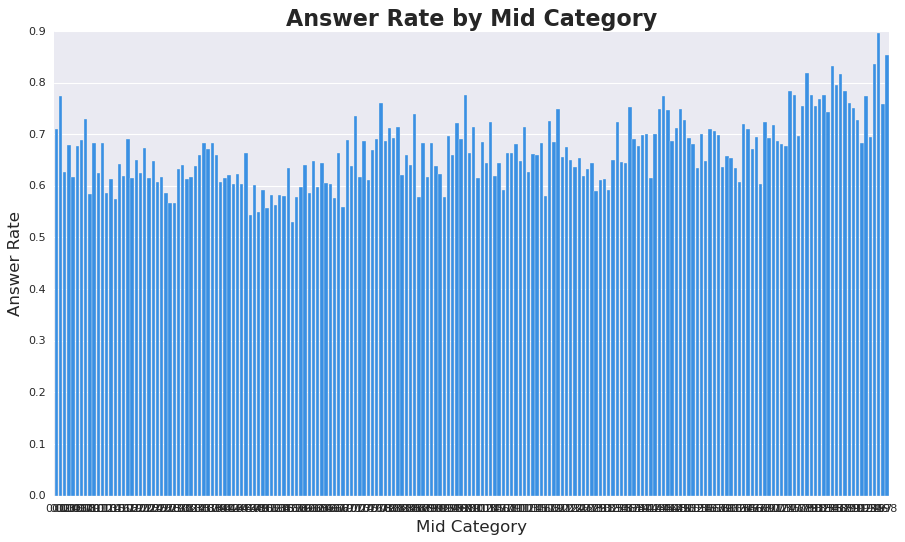

In [113]:
df = train.groupby('mid_category')['answerCode'].mean().reset_index()
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
q=sns.barplot(df,x='mid_category',y='answerCode', color="dodgerblue")
q=ax.set_xlabel("Mid Category", fontsize=15)
q=ax.set_ylabel("Answer Rate", fontsize=15)
q=ax.set_title("Answer Rate by Mid Category", fontsize=20, fontweight="semibold")
q=plt.show()

In [119]:
train[train.mid_category=='001'].big_category.unique()

array(['6', '9', '3', '8', '1', '4', '7', '2', '5'], dtype=object)

In [116]:
train.groupby('mid_category')['big_category'].apply(set).apply(len).reset_index()

,mid_category,big_category
0,001,9
1,002,9
2,003,9
3,004,9
4,005,9
5,006,9
6,007,9
7,008,9
8,009,9
9,010,9


In [78]:
for cat in cat_df.big_category.unique():
    

array(['1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)